In [1]:
# Disable TensorFlow debugging info and warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 2: Info and warnings not displayed 

In [2]:
import tensorflow as tf
import numpy as np
import skimage.io
import sklearn.ensemble
import matplotlib.pyplot as plt
import matplotlib
import pathlib
import tqdm
import annotation, misc, hyspec_io, hyspec_ml, image_render

In [3]:
# Paths
train_dataset_path = pathlib.Path(r'/media/mha114/Massimal/Bodo_Juvika/Hyperspectral/20220624/Area/3_PcaDatasets/train')
val_dataset_path = pathlib.Path(r'/media/mha114/Massimal/Bodo_Juvika/Hyperspectral/20220624/Area/3_PcaDatasets/validation')

In [4]:
# Load datasets
train_dataset = tf.data.experimental.load(str(train_dataset_path))
val_dataset = tf.data.experimental.load(str(val_dataset_path))

In [5]:
class_ind = {'Background':0,
             'Sand':1,
             'Seagrass / turf':2,
             'Rockweed':3,
             'Blue mussels':4,
             'Deep water':5}
class_ind_min = min(class_ind.values())
class_ind_max = max(class_ind.values())
tick_vals = [value + 0.5 for value in class_ind.values()]
tick_labels = list(class_ind.keys())

In [6]:
sample_weight_dict = {'Background':1,
                      'Sand':1,
                      'Seagrass / turf':4,
                      'Rockweed':2,
                      'Blue mussels':3,
                      'Deep water':1}

In [7]:
custom_cmap = matplotlib.colors.ListedColormap(colors=['lightgray','khaki','limegreen','sienna','dodgerblue','darkblue'])

b'Juvika_June2022_Pika_L_13'


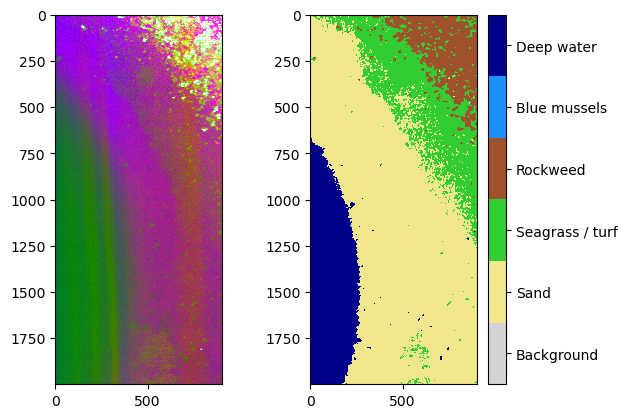

b'Juvika_June2022_Pika_L_20'


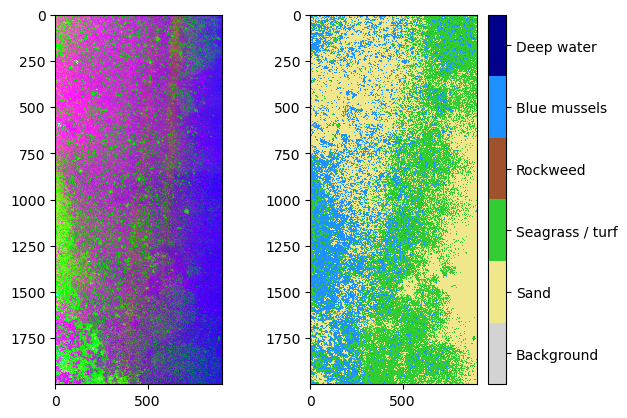

b'Juvika_June2022_Pika_L_21'


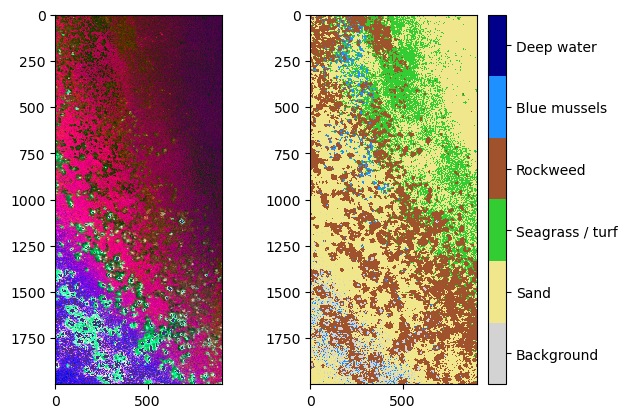

b'Juvika_June2022_Pika_L_24'


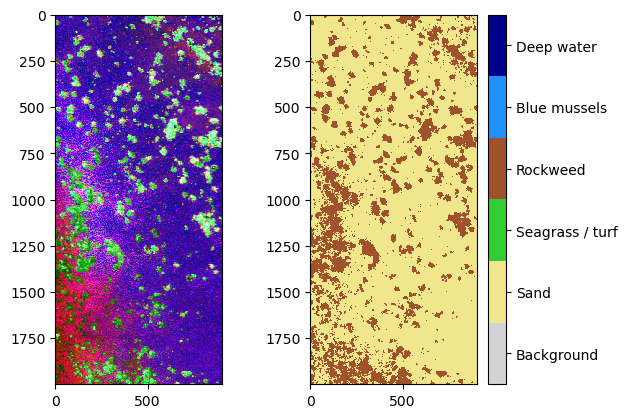

b'Juvika_June2022_Pika_L_25'


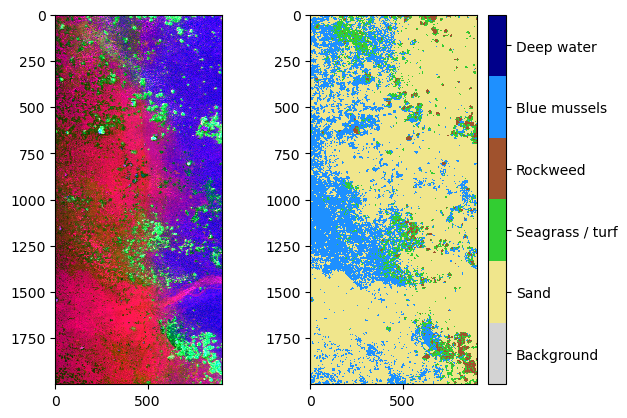

b'Juvika_June2022_Pika_L_30'


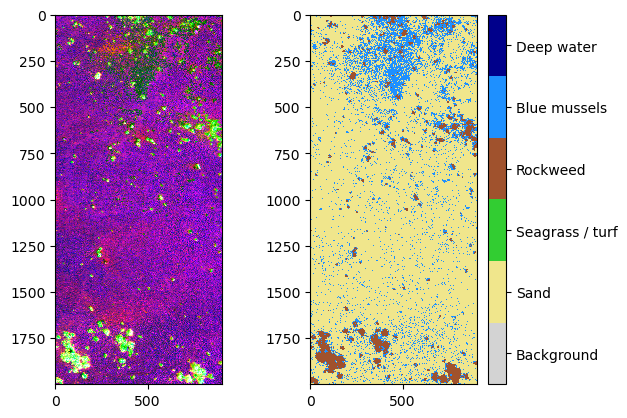

b'Juvika_June2022_Pika_L_31'


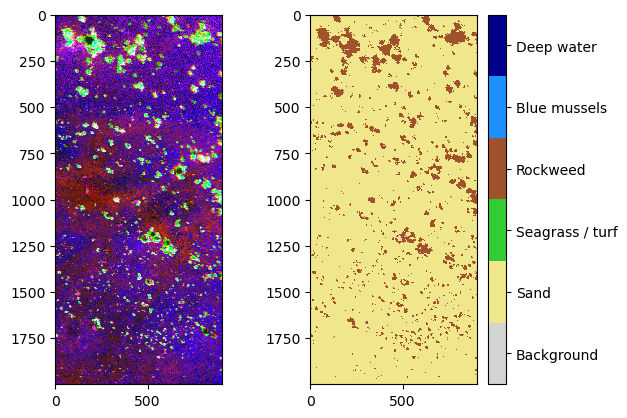

In [8]:
for pca_im,label_im,im_name in train_dataset.as_numpy_iterator():
    print(im_name)
    fig,ax = plt.subplots(nrows=1,ncols=2)
    im0 = ax[0].imshow(image_render.percentile_stretch(pca_im[:,:,[2,1,0]]),interpolation='none')    
    im1 = ax[1].imshow(label_im,interpolation='none',cmap=custom_cmap,vmin = class_ind_min, vmax=class_ind_max+1)
    cb = plt.colorbar(mappable=im1,ax=ax[1])
    cb.set_ticks(tick_vals)
    cb.set_ticklabels(tick_labels)
    plt.show()

In [9]:
# Vectorize training images
X_train = []
y_train = []
for pca_im,label_im,_ in train_dataset.as_numpy_iterator():
    X_train.append(np.reshape(pca_im,(-1,pca_im.shape[-1])))
    y_train.append(np.reshape(label_im,(-1)))
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

In [10]:
# Make sample weights
sample_weights_train = np.zeros_like(y_train,dtype=float)
for class_name, class_weight in sample_weight_dict.items():
    sample_weights_train[y_train==class_ind[class_name]] = class_weight

(array([8748317.,       0.,       0., 1399586.,       0.,       0.,
        1102837.,       0.,       0., 1349260.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

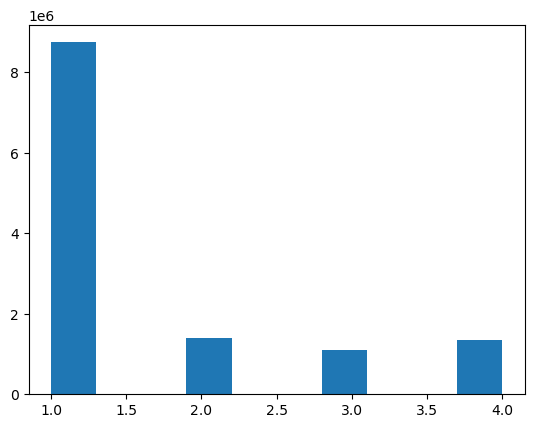

In [11]:
plt.hist(sample_weights_train)

In [12]:
# Make random forest classifier
#rfc = sklearn.ensemble.RandomForestClassifier(n_estimators=30,min_samples_leaf=0.001,max_samples=0.1)
#rfc = sklearn.ensemble.RandomForestClassifier(n_estimators=30,min_samples_leaf=0.0003,max_samples=0.1)
rfc = sklearn.ensemble.RandomForestClassifier(n_estimators=30,min_samples_leaf=0.0001,max_samples=0.1)

In [13]:
# Fit classifier
rfc.fit(X_train,y_train)

RandomForestClassifier(max_samples=0.1, min_samples_leaf=0.0001,
                       n_estimators=30)

In [14]:
# Vectorize validation images
X_val = []
y_val = []
for pca_im,label_im,_ in val_dataset.as_numpy_iterator():
    X_val.append(np.reshape(pca_im,(-1,pca_im.shape[-1])))
    y_val.append(np.reshape(label_im,(-1)))
X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)

In [15]:
# Predict
y_pred = rfc.predict(X_val)

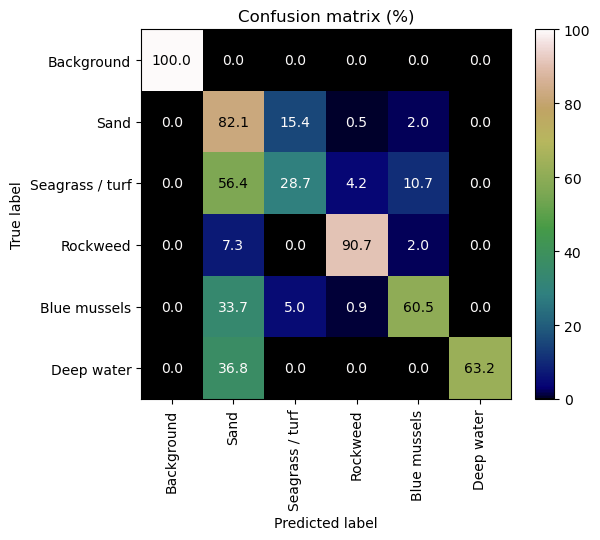

In [16]:
# Show confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(y_val,y_pred,normalize='true')
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix*100,display_labels=tick_labels)
disp.plot(xticks_rotation='vertical',cmap='gist_earth',values_format='.1f')
plt.title('Confusion matrix (%)')
plt.show()

In [17]:
n_params = sum(tree.tree_.node_count for tree in rfc.estimators_) * 5

In [18]:
n_params

202420

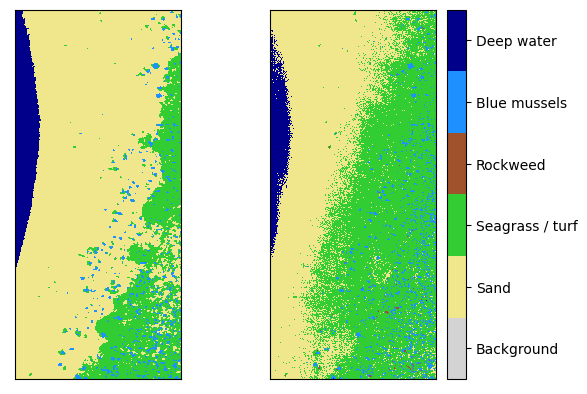

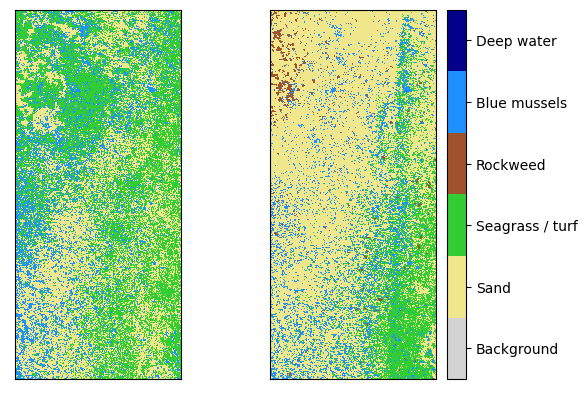

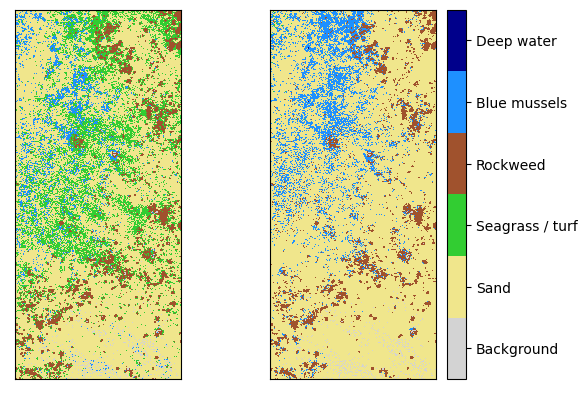

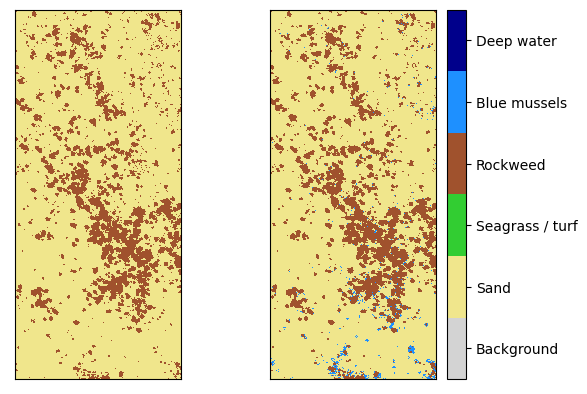

In [19]:
# Apply model to images
for pca_im,y_im,image_name in val_dataset.as_numpy_iterator():
    X_vec = np.reshape(pca_im,(-1,pca_im.shape[-1]))
    y_pred = rfc.predict(X_vec)
    y_pred_im = np.reshape(y_pred,y_im.shape)
    fig,ax = plt.subplots(nrows=1,ncols=2)
    
    im1 = ax[0].imshow(y_im,interpolation='none',cmap=custom_cmap,vmin = class_ind_min, vmax=class_ind_max+1)
    im1 = ax[1].imshow(y_pred_im,interpolation='none',cmap=custom_cmap,vmin = class_ind_min, vmax=class_ind_max+1)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    cb = plt.colorbar(mappable=im1,ax=ax[1])
    cb.set_ticks(tick_vals)
    cb.set_ticklabels(tick_labels)
    plt.show()